# ML Report - cardiovascular disease

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# load dataset and a first view of the dataset
df = pd.read_csv("../data/cardio_train.csv", sep=";").drop(columns="id")
df["age"] = (df["age"]/365).astype(int) # Convert age from days to years

# Cleaning outliers and feature engineering
Starting with creating of a BMI feature using following formula: 

BMI = $\frac{mass(kg)}{height(m)^2}$  

After creating of BMI-feature, cleaning data is necessary since there's alot of outliers.
While removing abnormal BMI values, limits for abnormality was set based on various BMI-charts online. BMIs above 70 and below 14 is extremely rare.
There may be real measures that's removed but if that's the case it only represents a very small part of the population. 

Cleaning of blood pressure values is necessary aswell, for both "ap_hi" and "ap_lo" the data includes many unreasonable values. To help with determination of the limits for what's "reasonable values", counsel with healtcare workers suggested the limits implemented.  
After cleaning outliers based on suggestion from healtcare workers, the categorical bloodpressure feature ("BP_cat") was implemented.  
The categories for different blood pressure categories is taken from: [Bloodpressure range](https://www.healthline.com/health/high-blood-pressure-hypertension#definition)



In [10]:
from helpers import categorical_bmi, categorical_bloodpressure # importing help-functions
# Feature BMI
df["BMI"] = round(df["weight"] / (df["height"].astype(float)/100)**2, 1)

# Filtering outliers from BMI, ap_hi, ap_lo
idx_drop = []
idx_drop.append(df.query("BMI > 70 or BMI < 14").index) # BMI outliers
idx_drop.append(df.query("ap_hi < 80 | ap_hi > 200 | ap_lo < 40 | ap_lo > 110").index) # Blood pressure outliers
idx_drop = [i for sublist in idx_drop for i in sublist] # Flatten index 2d list to 1d list
df.drop(idx_drop, inplace=True) # drop outliers

# Creating categorical features for blood pressure and BMI
df["BP_cat"] = df.apply(categorical_bloodpressure, axis=1)
df["BMI_cat"] = df["BMI"].apply(categorical_bmi)


## Visual representation

Viewing categorical  intr

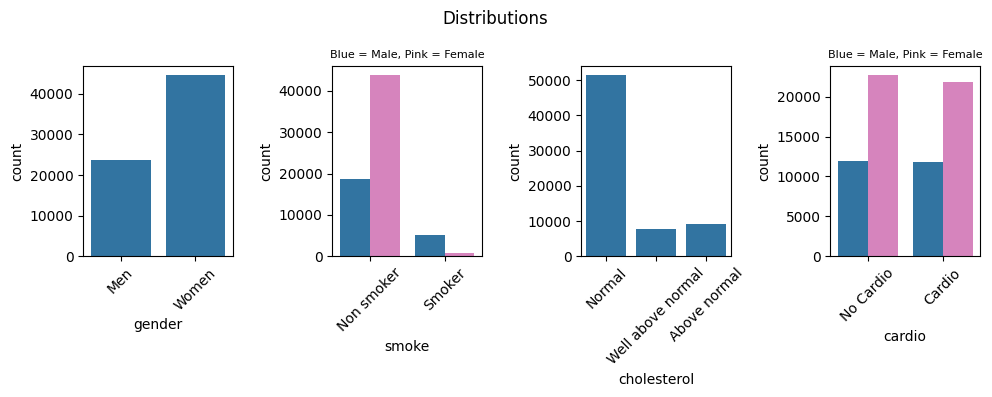

In [11]:
# EDA on dataset
from helpers import rename_columns

# Transform copy of df
df_copy = df.copy() 
df_renamed = rename_columns(df_copy)

# Setting up for plot variables for plots
cols_countplot = ["gender", "smoke", "cholesterol", "cardio"]
colors = sns.color_palette().as_hex()
blue, pink = colors[0], colors[6]

fig, axs = plt.subplots(nrows=1,ncols=len(cols_countplot), figsize=(10,4))
for i, col in enumerate(cols_countplot):
    if col in ["gender", "cholesterol"]:
        sns.countplot(ax=axs[i], x=df_renamed[col])
    else: 
        sns.countplot(ax=axs[i], x=df_renamed[col], hue=df_renamed["gender"], palette=[blue, pink], legend=None)
        axs[i].set_title("Blue = Male, Pink = Female", fontsize=8)
    axs[i].tick_params(axis="x", labelrotation=45)

fig.suptitle("Distributions")
fig.tight_layout()

plt.savefig("../visualizations/g-s-ch-c_distribution.png")


Längd och viktfördelning

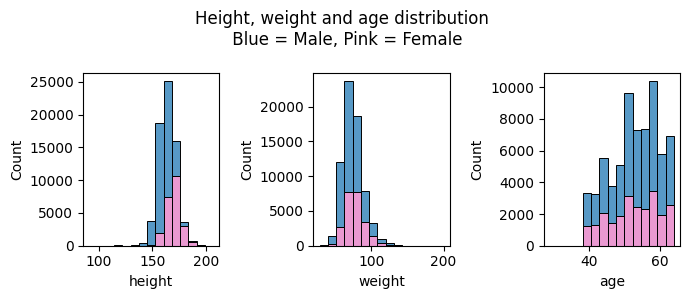

In [12]:
fig, axs = plt.subplots(1,3, figsize=(7,3))
cols_histplot = ["height", "weight", "age"]

for i, col in enumerate(cols_histplot):
    sns.histplot(ax=axs[i], data=df, x=col, hue="gender", palette=[blue,pink], bins=15, legend=None, multiple="stack")


fig.suptitle("Height, weight and age distribution \n Blue = Male, Pink = Female")
fig.tight_layout()

plt.savefig("../visualizations/h-w-a_distribution.png")

Text about heatmap
correlation between height and gender which is expected. The same for cholesterol and cluc. And smoke vs alcohol

Smoke  and gender might be correlated bacause women are more represented by tha data then men

Strong correlation between weight and BMI

<Axes: >

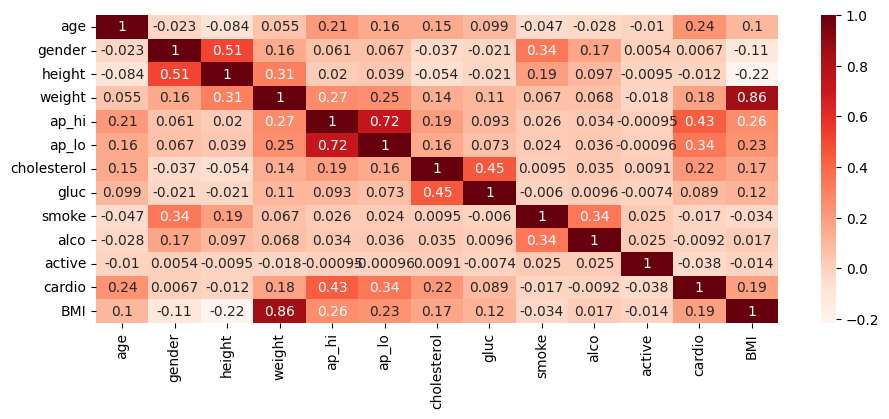

In [13]:
plt.figure(figsize=(11,4))
sns.heatmap(df.corr(numeric_only=True), cmap="Reds", annot=True)

## Create multiple datasets 1.2.2

In [22]:
from sklearn.model_selection import train_test_split

# Preparing different dataframes for algorithms
df1 = df.drop(columns=["ap_hi", "ap_lo", "height", "weight", "BMI"], axis="columns") # df with categorical features
df2 = df.drop(columns=["BMI_cat", "BP_cat", "height", "weight"], axis="columns") # df without categorical features
df1 = pd.get_dummies(data=df1, columns=["BMI_cat", "BP_cat", "gender"])
df2 = pd.get_dummies(data=df2, columns=["gender"])

X, y = df1.drop(columns="cardio", axis="columns"), df1["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=98)

,age,cholesterol,gluc,smoke,alco,active,cardio,BMI_cat_Normal,BMI_cat_Obese 1,BMI_cat_Obese 2,BMI_cat_Obese 3,BMI_cat_Overweight,BMI_cat_Underweight,BP_cat_Elevated,BP_cat_Hypertension 1,BP_cat_Hypertension 2,BP_cat_Hypertension crisis,BP_cat_Normal,gender_1,gender_2
0,50,1,1,0,0,1,0,True,False,False,False,False,False,False,True,False,False,False,False,True
1,55,3,1,0,0,1,1,False,True,False,False,False,False,False,False,True,False,False,True,False
2,51,3,1,0,0,0,1,True,False,False,False,False,False,False,True,False,False,False,True,False
3,48,1,1,0,0,1,1,False,False,False,False,True,False,False,False,True,False,False,False,True
4,47,1,1,0,0,0,0,True,False,False,False,False,False,False,False,False,False,True,True,False


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier


scaler = StandardScaler()

pipe_knn = Pipeline([("scaler", scaler), ("knn", KNeighborsClassifier())])
pipe_log = Pipeline([("scaler", scaler), ("log", LogisticRegression(penalty="elasticnet", solver="saga", max_iter=10000))])

params_knn =  {"knn__n_neighbors": list(range(1,50))}
params_log = {"log__l1_ratio": np.linspace(0, 1, 20)}

classifier_knn = GridSearchCV(estimator=pipe_knn, param_grid=params_knn, cv=5, scoring="accuracy")
classifier_log = GridSearchCV(estimator=pipe_log, param_grid=params_log, cv=5, scoring="accuracy")



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='accuracy')

### Train models on trainingdata

In [ ]:
classifier_knn.fit(X_train, y_train)

In [27]:
classifier_knn.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=44))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=44),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 44,
 'knn__p': 2,
 'knn__weights': 'uniform'}